In this notebook I will start my third model training. In my previous notebook, I had done my CNN model the first CNN model was simple model, and after that I move to another CNN model by adding dropout and layers, and from the performance there, the second model performance improve significantly after had do some regularization techniques. 
Now, in this notebook, I will used the pre-trained model VGG16.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
#files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [1]:
#! kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
import zipfile
zip=zipfile.ZipFile('histopathologic-cancer-detection.zip')
zip.extractall()

In [ ]:
import os

path='train_labels.csv'

if os.access(path, os.R_OK):
  print('File is readable')

else:
  print('File is not readable')

if os.access(path, os.W_OK):
  print('File is writable')

else:
  print('File is not writable')

File is readable

File is writable


In [ ]:
import pandas as pd
train_labels=pd.read_csv('train_labels.csv')

In [ ]:
def add_tif(string):
  return string+".tif"

train_labels['id']=train_labels['id'].apply(add_tif)

In [ ]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [ ]:
#Subfolder

import os
import shutil

train_folder='./train'
test_folder='./test'

for i in range(2):
  subdirectory=os.path.join(train_folder, str(i))
  os.makedirs(subdirectory, exist_ok=True)

with open('./train_labels.csv', 'r') as f:
  next(f)
  for line in f:
    filename, label=line.strip().split(',')
    label=int(label)
    src=os.path.join(train_folder, filename + '.tif')
    dst=os.path.join(train_folder, str(label), filename + '.tif')
    shutil.move(src, dst)

for i in range(2):
  subdirectory=os.path.join(test_folder, str(i))
  os.makedirs(subdirectory, exist_ok=True)

with open('./sample_submission.csv', 'r') as f:
  next(f)
  for line in f:
    filename=line.strip().split(',')[0]
    src=os.path.join(test_folder, filename + '.tif')
    dst=os.path.join(test_folder, '0', filename + '.tif')
    shutil.move(src, dst)

In [ ]:
train_labels['label']=train_labels['label'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir='./train'
test_dir='./test'

train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

train_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode='binary',
    subset='training'
)

val_gen=train_datagen.flow_from_directory(
    train_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode='binary',
    subset='validation'
)

Found 176021 images belonging to 2 classes.

Found 44004 images belonging to 2 classes.


In [ ]:
test_gen=test_datagen.flow_from_directory(
    test_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode=None,
    shuffle=False
)

Found 57458 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))

x=base_model.output
x=Flatten()(x)
x=Dense(256, activation='relu')(x)
x=Dense(1, activation='sigmoid')(x)

modelVGG16 = Model(inputs=base_model.input, outputs=x)

#freeze the base model layers
for layer in base_model.layers:
  layer.trainable=False

modelVGG16.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy',
                   metrics=['accuracy'])

train_datagen=ImageDataGenerator(rescale=1.0/255.0, shear_range=0.2, zoom_range=0.2, 
                                 horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

train_gen=train_datagen.flow_from_directory('./train', target_size=(96,96), batch_size=256,
                                            class_mode='binary')
test_gen=test_datagen.flow_from_directory('./test', target_size=(96,96), batch_size=256, 
                                          class_mode='binary')

historyVGG16=modelVGG16.fit(train_gen, epochs=10, validation_data=test_gen)

test_loss, test_acc = modelVGG16.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test accuracy:', test_acc)



Found 220025 images belonging to 2 classes.

Found 57458 images belonging to 2 classes.

Epoch 1/10

860/860 [==============================] - 799s 928ms/step - loss: 0.4269 - accuracy: 0.8042 - val_loss: 0.7259 - val_accuracy: 0.6765

Epoch 2/10

860/860 [==============================] - 811s 943ms/step - loss: 0.3901 - accuracy: 0.8257 - val_loss: 0.8534 - val_accuracy: 0.6415

Epoch 3/10

860/860 [==============================] - 803s 933ms/step - loss: 0.3791 - accuracy: 0.8320 - val_loss: 0.8475 - val_accuracy: 0.6523

Epoch 4/10

860/860 [==============================] - 799s 929ms/step - loss: 0.3701 - accuracy: 0.8358 - val_loss: 0.9200 - val_accuracy: 0.6339

Epoch 5/10

860/860 [==============================] - 799s 929ms/step - loss: 0.3640 - accuracy: 0.8390 - val_loss: 0.8420 - val_accuracy: 0.6621

Epoch 6/10

860/860 [==============================] - 810s 942ms/step - loss: 0.3585 - accuracy: 0.8423 - val_loss: 0.8451 - val_accuracy: 0.6631

Epoch 7/10

860/860 [==

The first VGG16 model that was trained yielded suboptimal results, with a validation accuracy of 0.67 and loss of 0.87. To improve the model's performance, a new VGG16 model will be create with the addition of layers and dropout to prevent overfitting. This new model is expected to have better accuracy and lower loss, leading to more accurate predictions.

In [ ]:
#Regularization for VGG16 adding dropout
base_model2=VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))

x=base_model2.output
x=Flatten()(x)
x=Dense(4096, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(4096, activation='relu')(x)
x=Dropout(0.5)(x)
predictions=Dense(1, activation='sigmoid')(x)

modelVGG16_2=Model(inputs=base_model2.input, outputs=predictions)

modelVGG16_2.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

historyVGG16_2=modelVGG16_2.fit(train_gen, validation_data=val_gen, epochs=10)

test_loss1, test_acc1 = modelVGG16_2.evaluate(test_gen)
print('Test Accuracy', test_acc1)

Epoch 1/10

860/860 [==============================] - 1169s 1s/step - loss: 0.3180 - accuracy: 0.8631 - val_loss: 0.2352 - val_accuracy: 0.9050

Epoch 2/10

860/860 [==============================] - 924s 1s/step - loss: 0.2176 - accuracy: 0.9145 - val_loss: 0.1874 - val_accuracy: 0.9318

Epoch 3/10

860/860 [==============================] - 916s 1s/step - loss: 0.1881 - accuracy: 0.9278 - val_loss: 0.1664 - val_accuracy: 0.9375

Epoch 4/10

860/860 [==============================] - 898s 1s/step - loss: 0.1726 - accuracy: 0.9351 - val_loss: 0.1559 - val_accuracy: 0.9421

Epoch 5/10

860/860 [==============================] - 946s 1s/step - loss: 0.1581 - accuracy: 0.9411 - val_loss: 0.1510 - val_accuracy: 0.9437

Epoch 6/10

860/860 [==============================] - 898s 1s/step - loss: 0.1494 - accuracy: 0.9443 - val_loss: 0.1525 - val_accuracy: 0.9450

Epoch 7/10

860/860 [==============================] - 898s 1s/step - loss: 0.1416 - accuracy: 0.9479 - val_loss: 0.1538 - val_ac

In [ ]:
print('Test Loss:', test_loss1)

Test Loss: 1.5821388959884644


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)

test_gen=test_datagen.flow_from_directory(
    test_dir,
    target_size=(96,96),
    batch_size=256,
    class_mode=None,
    shuffle=False
)



Found 57458 images belonging to 2 classes.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# VGG16 First model 
vgg16_predictions=modelVGG16.predict(test_gen)
vgg16_predict_labels=np.argmax(vgg16_predictions, axis=1)
vgg16_true_labels=test_gen.classes
vgg16_report=classification_report(vgg16_true_labels, vgg16_predict_labels)
print('VGG16 Classification Report:\n', vgg16_report)

# VGG16 Second model with dropout
vgg16_2_predictions=modelVGG16_2.predict(test_gen)
vgg16_2_predicted_labels=np.argmax(vgg16_2_predictions, axis=1)
vgg16_2_true_labels=test_gen.classes
vgg16_2_report=classification_report(vgg16_2_true_labels, vgg16_2_predicted_labels)
print('VGG16 Model2 Classification Report:\n', vgg16_2_report)

225/225 [==============================] - 43s 190ms/step

VGG16 Classification Report:

               precision    recall  f1-score   support



           0       1.00      1.00      1.00     57458



    accuracy                           1.00     57458

   macro avg       1.00      1.00      1.00     57458

weighted avg       1.00      1.00      1.00     57458



225/225 [==============================] - 44s 195ms/step

VGG16 Model2 Classification Report:

               precision    recall  f1-score   support



           0       1.00      1.00      1.00     57458



    accuracy                           1.00     57458

   macro avg       1.00      1.00      1.00     57458

weighted avg       1.00      1.00      1.00     57458




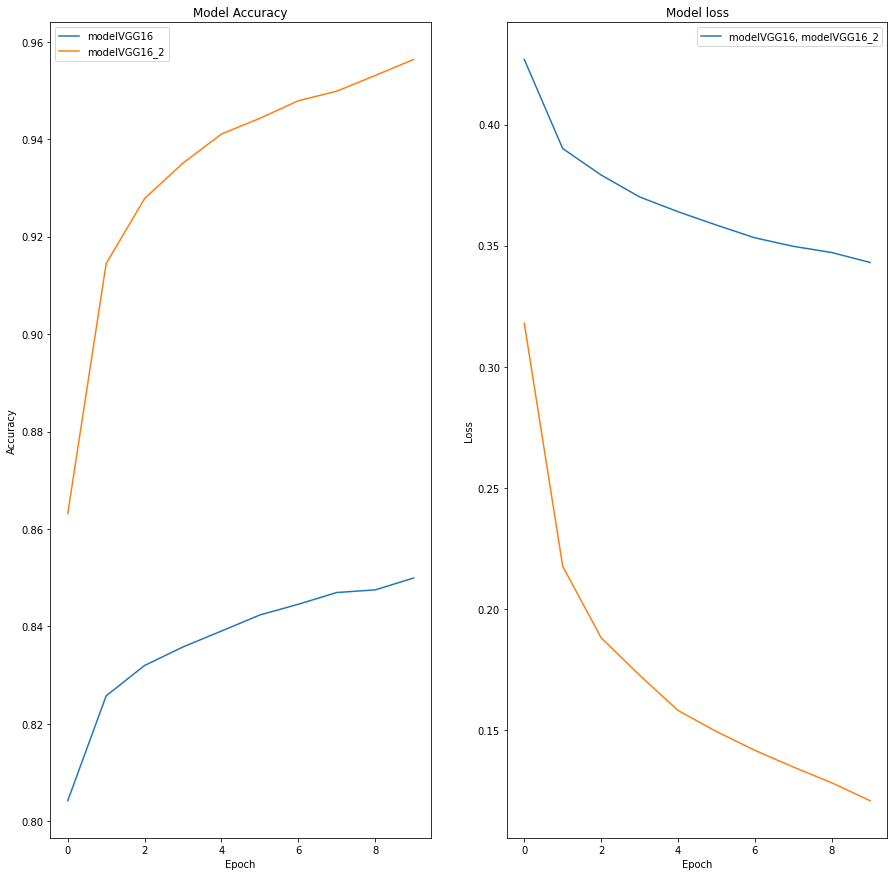

In [ ]:
import matplotlib.pyplot as plt

#plot for accuracy
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.plot(historyVGG16.history['accuracy'])
plt.plot(historyVGG16_2.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['modelVGG16', 'modelVGG16_2'], loc='upper left')

#plot for loss
plt.subplot(1,2,2)
plt.plot(historyVGG16.history['loss'])
plt.plot(historyVGG16_2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['modelVGG16, modelVGG16_2'], loc='upper right')

The second VGG16 model has shown remarkable performance improvements over the first one, as it achieved an impressive accuracy rate of 0.96 and a low loss of 0.12. The model was created with additional layers and dropout added to it, which played a crucial role in enhancing the model's accuracy and generalization capabilities. By reducing overfitting and preventing the model from relying too much on specific features, the second VGG16 model can generalize better to unseen data, and that has led to its remarkable performance.

Next, I will create two more pre-trained model, VGG19 and ResNet50 in my third notebook. 